# Experiment 1: Performance
## How does the gazetteer-enhanced T5-ASP model perform compared to other NER models and in terms of contextual learning of entities?

### Datasets

In [22]:
import json

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_train.json", encoding="utf-8") as file:
    lowner_train = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_dev.json", encoding="utf-8") as file:
    lowner_dev = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_test.json", encoding="utf-8") as file:
    lowner_test = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_gazetteer.json", encoding="utf-8") as file:
    lowner_gazetteer = json.load(file)

with open(
        "/home/loebbert/projects/thesis/data/multiconer/multiconer_test.json",
        encoding="utf-8") as file:
    multiconer_test = json.load(file)

In [8]:
datasets = [
    lowner_train, lowner_dev, lowner_test, lowner_gazetteer, multiconer_test,
    lowner_gazetteer + multiconer_test,
    lowner_train + lowner_gazetteer + multiconer_test
]
names = [
    "lowner_train",
    "lowner_dev",
    "lowner_test",
    "lowner_gazetteer",
    "multiconer_test",
    "lowner_gazetteer-multiconer_test",
    "lowner_train-lowner_gazetteer-multiconer_test",
]

### Dataset metrics

In [ ]:
from data_metrics.entity_coverage_ratio import confusion_matrix_expected_entity_coverage_ratio



cm_expected_entity_coverage = confusion_matrix_expected_entity_coverage_ratio(datasets, names)


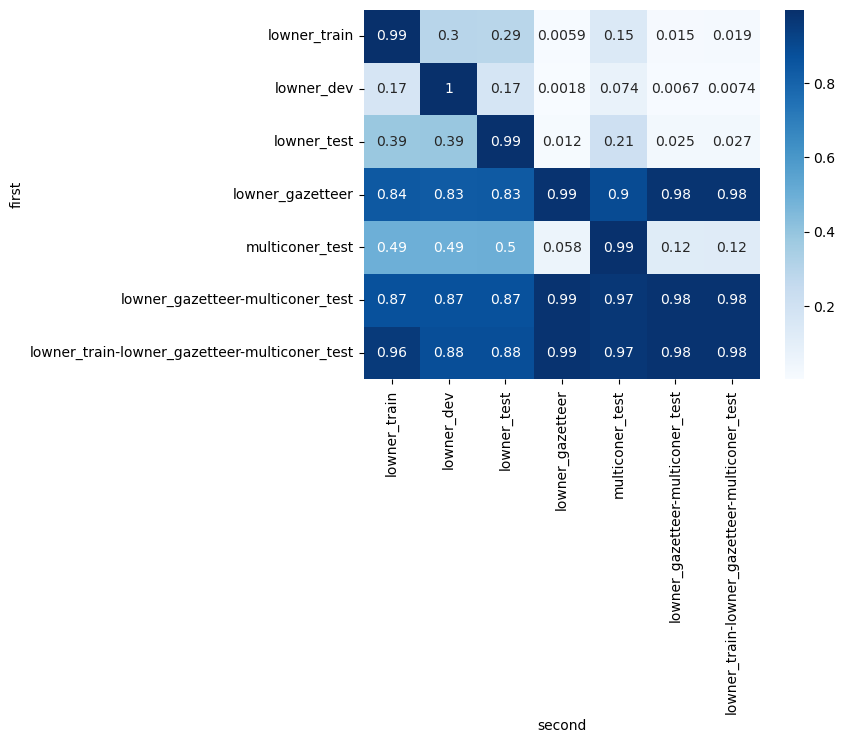

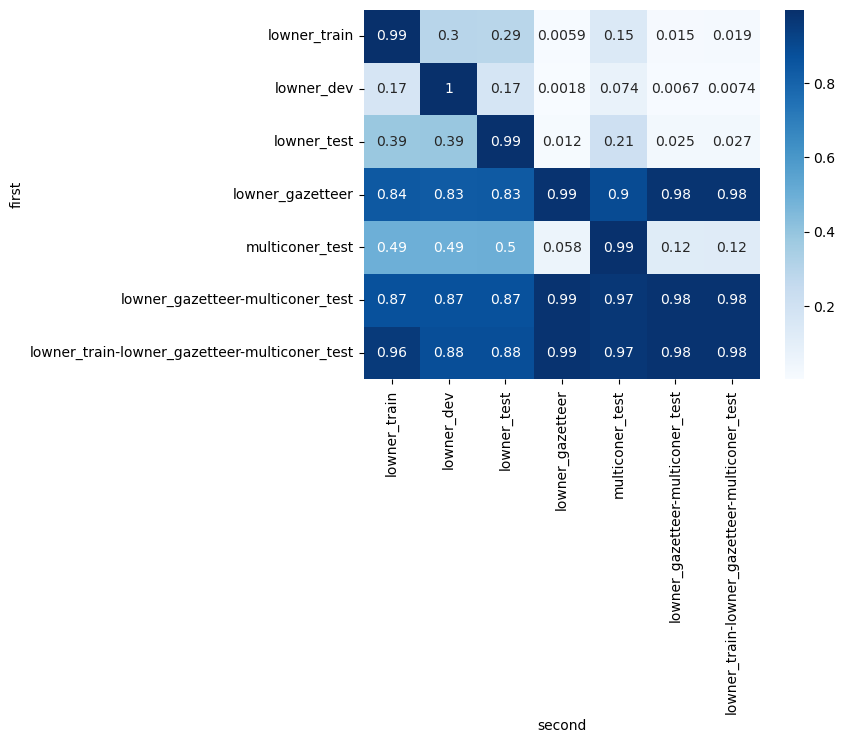

In [10]:
from data_metrics.utils import visualize_confusion_matrix

visualize_confusion_matrix(cm_expected_entity_coverage,
                           "expected_entity_coverage_ratio")

## Get expected entity coverage ratio for search results

In [2]:
from configs.asp_t5 import T5_BASE, FLAN_T5_BASE

t5_asp_fetahugaz_sent = T5_BASE.copy()
t5_asp_fetahugaz_sent.update({
    "adam_weight_decay": 0.011738749999999989,
    "asp_dropout_rate": 0.4540625,
    "asp_hidden_dim": 633,
    "gaz_search_algorithm": "bm25",
    "gaz_search_topk": 6,
    "gaz_use_mentions": False,
    "num_epochs": 16,
    "plm_learning_rate": 0.00017496219281663535,
    "search_join_method": "reciprocal_rank_fusion",
    "search_topk": 8,
    "sent_search_algorithm": "ann",
    "sent_search_topk": 6,
    "sent_use_mentions": True,
    "task_learning_rate": 0.0035849253731343286,
    "train_search_dropout": 0.05492957746478871,
    "warmup_ratio": 0.37917808219178084,
    "name": "t5_asp_fetahugaz_sent"
})

t5_asp_fetahugaz = FLAN_T5_BASE.copy()
t5_asp_fetahugaz.update({
    "adam_weight_decay": 0.011738749999999989,
    "asp_dropout_rate": 0.4540625,
    "asp_hidden_dim": 633,
    "num_epochs": 16,
    "plm_learning_rate": 0.00017496219281663535,
    "search_algorithm": "bm25",
    "search_topk": 8,
    "task_learning_rate": 0.0035849253731343286,
    "train_search_dropout": 0.05492957746478871,
    "use_mentions": False,
    "warmup_ratio": 0.37917808219178084,
    "name": "t5_asp_fetahugaz"
})

t5_asp_gaz = FLAN_T5_BASE.copy()
t5_asp_gaz.update({
    "adam_weight_decay": 0.018862500000000015,
    "asp_dropout_rate": 0.43875,
    "asp_hidden_dim": 799,
    "num_epochs": 17,
    "plm_learning_rate": 0.00020887755102040807,
    "search_algorithm": "bm25",
    "search_topk": 6,
    "task_learning_rate": 0.003949473684210526,
    "train_search_dropout": 0.028260869565217374,
    "use_mentions": False,
    "warmup_ratio": 0.20864864864864865,
    "name": "t5_asp_gaz"
})

t5_asp_gaz_sent = T5_BASE.copy()
t5_asp_gaz_sent.update({
    "adam_weight_decay": 0.011738749999999989,
    "asp_dropout_rate": 0.4540625,
    "asp_hidden_dim": 633,
    "gaz_search_algorithm": "bm25",
    "gaz_search_topk": 6,
    "gaz_use_mentions": False,
    "num_epochs": 24,
    "plm_learning_rate": 0.00017496219281663535,
    "search_join_method": "reciprocal_rank_fusion",
    "search_topk": 8,
    "sent_search_algorithm": "ann",
    "sent_search_topk": 6,
    "sent_use_mentions": True,
    "task_learning_rate": 0.0035849253731343286,
    "train_search_dropout": 0.05492957746478871,
    "warmup_ratio": 0.37917808219178084,
    "name": "t5_asp_gaz_sent"
})

t5_asp_sent = T5_BASE.copy()
t5_asp_sent.update({
    "adam_weight_decay": 0.49637507889057786,
    "asp_dropout_rate": 0.3,
    "asp_hidden_dim": 142,
    "num_epochs": 20,
    "plm_learning_rate": 5e-05,
    "search_algorithm": "ann",
    "search_topk": 8,
    "task_learning_rate": 0.0013480523331922776,
    "train_search_dropout": 0.21126587935893093,
    "use_mentions": True,
    "warmup_ratio": 0.184451637360714,
    "name": "t5_asp_sent"
})


{'plm_pretrained_name_or_path': 't5-base', 'plm_tokenizer_name': 't5-small', 'model_max_length': 4096, 'mention_start_token': '<m>', 'mention_end_token': '</m>', 'asp_hidden_dim': 633, 'asp_dropout_rate': 0.4540625, 'asp_init_std': 0.02, 'asp_activation': 'relu', 'num_labels': 6, 'max_nest_depth': 1, 'beam_size': 1, 'plm_learning_rate': 0.00017496219281663535, 'plm_scheduler': 'linear_with_warmup', 'task_learning_rate': 0.0035849253731343286, 'task_scheduler': 'linear_with_warmup', 'adam_eps': 1e-08, 'adam_weight_decay': 0.011738749999999989, 'warmup_ratio': 0.37917808219178084, 'num_epochs': 16, 'gradient_accumulation_steps': 1, 'batch_size': 40, 'train_len': 0, 'fused': None, 'gaz_search_algorithm': 'bm25', 'gaz_search_topk': 6, 'gaz_use_mentions': False, 'search_join_method': 'reciprocal_rank_fusion', 'search_topk': 8, 'sent_search_algorithm': 'ann', 'sent_search_topk': 6, 'sent_use_mentions': True, 'train_search_dropout': 0.05492957746478871, 'name': 't5_asp_fetahugaz_sent'}


In [14]:
from hyperparameter_tuning.t5_asp_fetahugaz_sent import setup_database as setup_database_fetahugaz_sent
from hyperparameter_tuning.t5_asp_gaz_sent import setup_database as setup_database_gaz_sent
from hyperparameter_tuning.t5_asp_fetahugaz import setup_database as setup_database_fetahugaz
from hyperparameter_tuning.t5_asp_gaz import setup_database as setup_database_gaz
from hyperparameter_tuning.t5_asp_sent import setup_database as setup_database_sent
from hyperparameter_tuning.training import get_search_results
from lightning.fabric.utilities.seed import seed_everything
import pickle
from data_metrics.entity_coverage_ratio import entity_coverage_ratio
import pandas as pd
import os

seeds = [1, 2, 3]
search_result_eecr = []

for seed in seeds:
    # seed
    seed_everything(seed)

    for config in [
        t5_asp_fetahugaz_sent, t5_asp_fetahugaz, t5_asp_gaz, t5_asp_gaz_sent, t5_asp_sent
    ]:

        # setup database
        if config["name"] == "t5_asp_fetahugaz_sent":
            search = setup_database_fetahugaz_sent(
                config["sent_search_algorithm"],
                config["sent_search_topk"],
                config["gaz_search_algorithm"],
                config["gaz_search_topk"],
                config["search_join_method"],
                config["search_topk"],
            )
        if config["name"] == "t5_asp_gaz_sent":
            search = setup_database_gaz_sent(
                config["sent_search_algorithm"],
                config["sent_search_topk"],
                config["gaz_search_algorithm"],
                config["gaz_search_topk"],
                config["search_join_method"],
                config["search_topk"],
            )
        if config["name"] == "t5_asp_fetahugaz":
            search = setup_database_fetahugaz(
                config["search_algorithm"],
                config["search_topk"]
            )
        if config["name"] == "t5_asp_gaz":
            search = setup_database_gaz(config["search_algorithm"],
                                              config["search_topk"])
        if config["name"] == "t5_asp_sent":
            search = setup_database_sent(config["search_algorithm"],
                                        config["search_topk"])

        # go through all datasets
        for dataset, dataset_name in [(lowner_train, "lowner_train"),
                                    (lowner_dev, "lowner_dev"),
                                    (lowner_test, "lowner_test")
                                    ]:

            search_results = get_search_results(
                search, dataset)

            # save search results for augmentation
            file_name = os.path.join(
                "/home/loebbert/projects/thesis", "experiments", "01_performance", "search_results", f"{str(seed)}_{config['name']}_{dataset_name}.pkl")

            with open(file_name, "wb") as file:
                pickle.dump(search_results, file)

            # calculate the expected entity coverage ratio for each sample
            for idx, item in enumerate(dataset):
                results = [doc.to_dict() for doc in search_results[idx]]
                _, _, first_filtered = entity_coverage_ratio(results, [item])
                search_result_eecr.append({
                    "dataset": dataset_name,
                    "model": config["name"],
                    "doc_id": item["doc_id"],
                    "seed": seed,
                    "eecr": first_filtered
                })

df = pd.DataFrame.from_records(search_result_eecr)
file_name = os.path.join(
    "/home/loebbert/projects/thesis", "experiments", "01_performance",
    "search_result_eecr_df.pkl"
)
df.to_pickle(file_name)

Global seed set to 1


NameError: name 't5_asp_fetahugaz_sent' is not defined

In [62]:
import pandas as pd
import os

eecr_df = pd.read_pickle(os.path.join("/home/loebbert/projects/thesis", "experiments",
                         "01_performance", "search_result_eecr_df.pkl"))
eecr_df.head()

,dataset,model,doc_id,seed,eecr
0,lowner_train,t5_asp_fetahugaz_sent,lowner_train_0,1,1.0
1,lowner_train,t5_asp_fetahugaz_sent,lowner_train_1,1,0.0
2,lowner_train,t5_asp_fetahugaz_sent,lowner_train_2,1,0.0
3,lowner_train,t5_asp_fetahugaz_sent,lowner_train_3,1,0.0
4,lowner_train,t5_asp_fetahugaz_sent,lowner_train_4,1,0.0


In [64]:
mean_df = eecr_df.pivot_table(values="eecr",
                              index=["model", "dataset", "seed"],
                              aggfunc="mean").reset_index()
mean_df.head()

,model,dataset,seed,eecr
0,t5_asp_fetahugaz,lowner_dev,1,0.501011
1,t5_asp_fetahugaz,lowner_dev,2,0.501011
2,t5_asp_fetahugaz,lowner_dev,3,0.501011
3,t5_asp_fetahugaz,lowner_test,1,0.507653
4,t5_asp_fetahugaz,lowner_test,2,0.507653


In [27]:
mean_df_mean = mean_df.groupby(["model", "dataset"])["eecr"].mean().reset_index()
mean_df_std = mean_df.groupby(["model", "dataset"])["eecr"].std().reset_index()

In [31]:
mean_df_mean.pivot_table(values="eecr", index="model", columns="dataset")


dataset,lowner_dev,lowner_test,lowner_train
model,,,
t5_asp_fetahugaz,0.501011,0.507653,0.499984
t5_asp_fetahugaz_sent,0.546537,0.549414,0.545299
t5_asp_gaz,0.297961,0.302970,0.301045
t5_asp_gaz_sent,0.333373,0.339839,0.338090
t5_asp_sent,0.226344,0.228097,0.229293


In [32]:
mean_df_std.pivot_table(values="eecr", index="model", columns="dataset")

dataset,lowner_dev,lowner_test,lowner_train
model,,,
t5_asp_fetahugaz,0.0,0.0,0.0
t5_asp_fetahugaz_sent,0.0,0.0,0.0
t5_asp_gaz,0.0,0.0,0.0
t5_asp_gaz_sent,0.0,0.0,0.0
t5_asp_sent,0.0,0.0,0.0


### Context Coverage Ratio for Search results

In [58]:
import pandas as pd
import os

ccr_df = pd.read_pickle(
    os.path.join("/home/loebbert/projects/thesis", "experiments",
                 "01_performance", "search_result_ccr_df.pkl"))
ccr_df.head()

,dataset,model,seed,doc_id,cosine_full_max,cosine_full_mean,cosine_full_min,cosine_windowed_max,cosine_windowed_mean,cosine_windowed_min
0,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_0,0.656148,0.586906,0.415838,0.642543,0.514641,0.341941
1,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_1,0.696868,0.448836,0.067061,0.611117,0.418860,0.067061
2,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_2,0.561679,0.295702,0.030874,0.367668,0.176491,0.030874
3,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_3,0.631569,0.492404,0.305296,0.592315,0.419323,0.169089
4,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_4,0.482656,0.275889,0.013596,0.445746,0.242780,0.013596


In [60]:
def get_confusion_matrix_for_samples(df: pd.DataFrame, value: str):
    agg_df = df.pivot_table(values=value,
                                 index=["model", "dataset", "seed"],
                                 aggfunc="mean").reset_index()
    agg_mean_df = agg_df.groupby(
        ["model", "dataset"])[value].mean().reset_index()
    agg_std_df = agg_df.groupby(
        ["model", "dataset"])[value].std().reset_index()

    return agg_mean_df.pivot_table(values=value,
                                   index="model",
                                   columns="dataset"), agg_std_df.pivot_table(
                                       values=value,
                                       index="model",
                                       columns="dataset")


In [65]:
cm_eecr, _ = get_confusion_matrix_for_samples(eecr_df, "eecr")
cm_eecr

dataset,lowner_dev,lowner_test,lowner_train
model,,,
t5_asp_fetahugaz,0.501011,0.507653,0.499984
t5_asp_fetahugaz_sent,0.546537,0.549414,0.545299
t5_asp_gaz,0.297961,0.302970,0.301045
t5_asp_gaz_sent,0.333373,0.339839,0.338090
t5_asp_sent,0.226344,0.228097,0.229293


In [61]:
top1_full_ccr, _ = get_confusion_matrix_for_samples(ccr_df, "cosine_full_max")
topk_full_ccr, _ = get_confusion_matrix_for_samples(ccr_df, "cosine_full_mean")
top1_windowed_ccr, _ = get_confusion_matrix_for_samples(ccr_df, "cosine_windowed_max")
topk_windowed_ccr, _ = get_confusion_matrix_for_samples(
    ccr_df, "cosine_windowed_mean")
print(top1_full_ccr, top1_windowed_ccr, sep="\n\n", end="\n\n\n")
print(topk_full_ccr, topk_windowed_ccr, sep="\n\n")

dataset                lowner_dev  lowner_test  lowner_train
model                                                       
t5_asp_fetahugaz         0.509699     0.509369      0.506632
t5_asp_fetahugaz_sent    0.655171     0.654860      0.654014
t5_asp_gaz               0.439140     0.438694      0.437252
t5_asp_gaz_sent          0.639547     0.640249      0.639583
t5_asp_sent              0.633957     0.634750      0.634064

dataset                lowner_dev  lowner_test  lowner_train
model                                                       
t5_asp_fetahugaz         0.509699     0.509369      0.506632
t5_asp_fetahugaz_sent    0.609466     0.609333      0.608265
t5_asp_gaz               0.439140     0.438694      0.437252
t5_asp_gaz_sent          0.587355     0.588206      0.587806
t5_asp_sent              0.592531     0.592988      0.592951


dataset                lowner_dev  lowner_test  lowner_train
model                                                       
t5_asp_fetahugaz     

## Pearson correlation

In [102]:
from scipy.stats import pearsonr


def per_sample_pearsonr(first_df: pd.DataFrame,
                    second_df: pd.DataFrame,
                    model: str,
                    dataset: str,
                    first_metric: str,
                    second_metric: str,
                    alternative: str = "two-sided"):
    first_filtered = first_df[(first_df["model"] == model)
                   & (first_df["dataset"] == dataset)].groupby(
                       ["seed", "doc_id"]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df[(second_df["model"] == model)
                                & (second_df["dataset"] == dataset)].groupby([
                                    "seed", "doc_id"
                                ]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df


{'statistic': 0.4663031042470116, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.46146256022122517, high=0.471115885034108)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

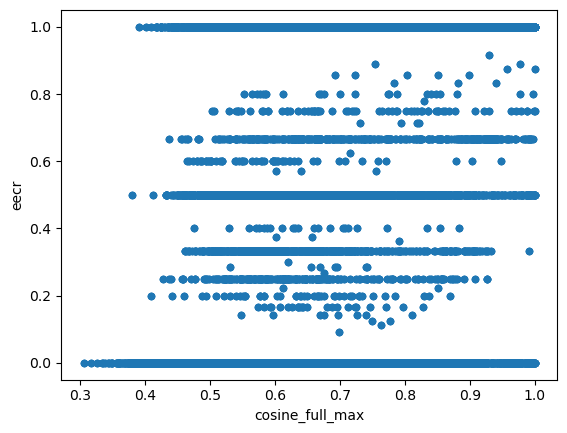

In [103]:
result, df = per_sample_pearsonr(eecr_df, ccr_df, "t5_asp_sent", "lowner_test",
                                 "eecr", "cosine_full_max")
print({
    "statistic": result.statistic,
    "p-value": result.pvalue,
    "confidence_interval": result.confidence_interval()
})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.46630310424701166. This indicates a moderate positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.4614625602212253, 0.4711158850341081]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, reinforcing the interpretation of a strong positive correlation.

Considering the moderate positive correlation, statistically significant p-value, and narrow confidence interval, this result suggests a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data.

In [104]:
def per_model_pearsonr(first_df: pd.DataFrame,
                         second_df: pd.DataFrame,
                         model: str,
                         first_metric: str,
                         second_metric: str,
                         alternative: str = "two-sided"):
    first_filtered = first_df[(first_df["model"] == model)].groupby(["seed", "doc_id"]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df[(second_df["model"] == model)].groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df


def per_dataset_pearsonr(first_df: pd.DataFrame,
                         second_df: pd.DataFrame,
                         dataset: str,
                         first_metric: str,
                         second_metric: str,
                         alternative: str = "two-sided"):
    first_filtered = first_df[(first_df["dataset"] == dataset)].groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df[(second_df["dataset"] == dataset)].groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df

{'statistic': 0.45770827115306667, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.45371655729192883, high=0.46168161831674936)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

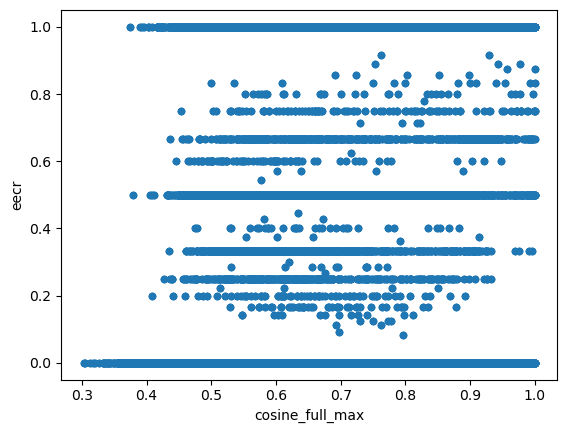

In [105]:
result, df = per_model_pearsonr(eecr_df, ccr_df, "t5_asp_sent", "eecr",
                                "cosine_full_max")
print({
    "statistic": result.statistic,
    "p-value": result.pvalue,
    "confidence_interval": result.confidence_interval()
})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.45770827115305757. This indicates a moderate positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.45078268209846245, 0.4645787592096722]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, further supporting the interpretation of a strong positive correlation.

Considering the moderate positive correlation, statistically significant p-value, and narrow confidence interval, this result suggests a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data.

{'statistic': 0.5350648828403991, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.5306483690889736, high=0.5394523423155144)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

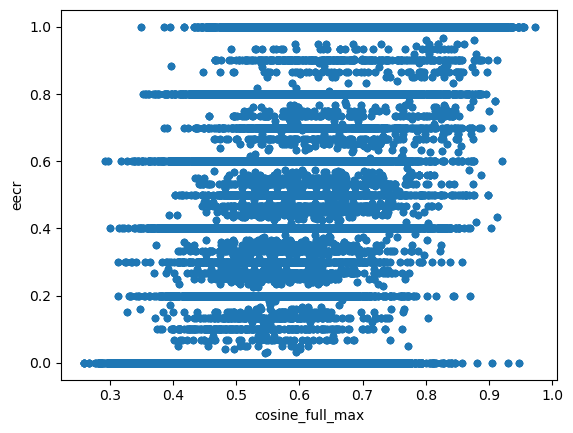

In [106]:
result, df = per_dataset_pearsonr(eecr_df, ccr_df, "lowner_test", "eecr",
                                  "cosine_full_max")
print({"statistic":result.statistic, "p-value":result.pvalue, "confidence_interval":result.confidence_interval()})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.5350648828403948. This indicates a moderate to strong positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.5273966364017278, 0.5426459637936389]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, further supporting the interpretation of a strong positive correlation.

Considering the strong positive correlation, statistically significant p-value, and narrow confidence interval, this result indicates a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data. Overall, this is a solid and convincing result.

In [107]:
def overall_pearsonr(first_df: pd.DataFrame,
                     second_df: pd.DataFrame,
                     first_metric: str,
                     second_metric: str,
                     alternative: str = "two-sided"):
    first_filtered = first_df.groupby(["seed", "doc_id"
                                       ]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df.groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df

{'statistic': 0.5327233226843491, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.5291054088919651, high=0.5363218687292708)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

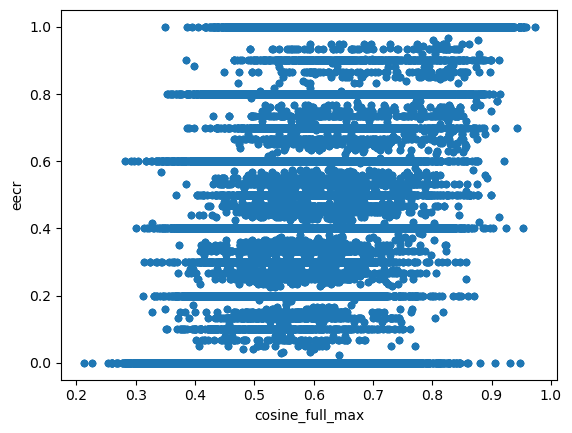

In [108]:
result, df = overall_pearsonr(eecr_df, ccr_df, "eecr", "cosine_full_max")
print({
    "statistic": result.statistic,
    "p-value": result.pvalue,
    "confidence_interval": result.confidence_interval()
})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.5327233226843386. This indicates a moderate to strong positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.526444524769772, 0.5389440161823984]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, further supporting the interpretation of a strong positive correlation.

Considering the strong positive correlation, statistically significant p-value, and narrow confidence interval, this result indicates a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data.